# Dependencies

In [9]:
import numpy as np
from scipy.linalg import eigh, eigvalsh_tridiagonal
import matplotlib.pyplot as plt
import csv

## Plot params

In [2]:
# Set font sizes globally
plt.rcParams['font.size'] = 16  # General font size
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size

# Functions

In [3]:
# Generate the Hamiltonian matrix for a given Mz sector and chain length L
def generate_hamiltonian(L, Delta):
    dim = 2**L
    H = np.zeros((dim, dim), dtype=complex)
    for state in range(dim):
        for i in range(L):
            j = (i + 1) % L  # Periodic boundary conditions
            si = (state >> i) & 1
            sj = (state >> j) & 1
            H[state, state] += Delta * (0.25 if si == sj else -0.25)
            if si != sj:
                flip_state = state ^ (1 << i) ^ (1 << j)
                H[state, flip_state] += 0.5
    return H

In [4]:
# Lanczos algorithm for lowest eigenvalues
def lanczos(H, num_eigenvalues=5, max_iter=100):
    n = H.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)
    alpha = []
    beta = []
    V = [v]
    w = H @ v
    alpha.append(np.vdot(v, w).real)
    w -= alpha[0] * v
    beta.append(np.linalg.norm(w))

    for _ in range(1, max_iter):
        if beta[-1] == 0:
            break
        v = w / beta[-1]
        V.append(v)
        w = H @ v
        alpha.append(np.vdot(v, w).real)
        w -= alpha[-1] * v + beta[-1] * V[-2]
        beta.append(np.linalg.norm(w))

    T_diag = np.array(alpha)
    T_subdiag = np.array(beta[:-1])
    eigvals = eigvalsh_tridiagonal(T_diag, T_subdiag)[:num_eigenvalues]
    return eigvals

In [5]:
# Function to filter states by magnetization sector
def get_states_in_sector(L, Mz):
    states = []
    for state in range(2**L):
        magnetization = np.sum([(state >> i) & 1 for i in range(L)]) - L / 2
        if magnetization == Mz:
            states.append(state)
    return states

In [6]:
# Function to compute the ground-state energy for multiple sizes and anisotropies
def compute_ground_state_energy(L_values, Delta_values):
    results = {}
    for Delta in Delta_values:
        energies = []
        for L in L_values:
            H = generate_hamiltonian(L, Delta)
            states = get_states_in_sector(L, 0)
            H_reduced = H[np.ix_(states, states)]
            eigvals = lanczos(H_reduced, num_eigenvalues=5)
            ground_energy = eigvals[0] / L
            energies.append(ground_energy)
        results[Delta] = energies
    return results

In [7]:
# # Function to compute ground state energy for a given Mz sector
def ground_state_energy(L, Delta, Mz):
    H_full = generate_hamiltonian(L, Delta)
    states = get_states_in_sector(L, Mz)
    H_reduced = H_full[np.ix_(states, states)]
    return eigh(H_reduced, eigvals_only=True)[0]  # Ground state energy

# b

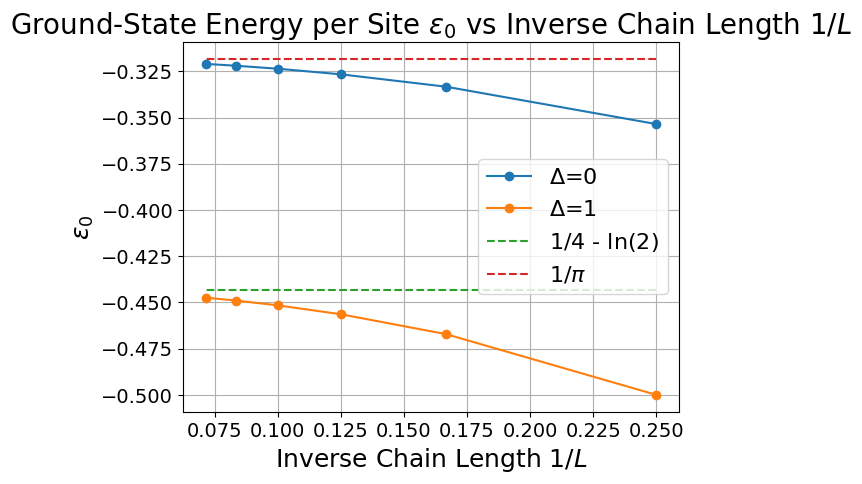

In [11]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

# Spin operators
Sx = sigma_x / 2
Sy = sigma_y / 2
Sz = sigma_z / 2
Sp = np.array([[0, 1], [0, 0]], dtype=complex)
Sm = np.array([[0, 0], [1, 0]], dtype=complex)

# Parameters
L_values = [4, 6, 8, 10, 12, 14]
Delta_values = [0, 1]
results = compute_ground_state_energy(L_values, Delta_values)

with open("Data02/b_ground_state.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["L", "1/L", "Delta", "Ground-State Energy"])
    # Write data
    for Delta, energies in results.items():
        for L, energy in zip(L_values, energies):
            writer.writerow([L, 1/L, Delta, energy])



# Plotting ground-state energy per site vs inverse chain length
for Delta, energies in results.items():
    plt.plot([1/L for L in L_values], energies, marker='o', label=f"$\Delta$={Delta}")
plt.plot([1/L for L in L_values], [1/4 - np.log(2) for L in L_values], ls = '--', label = "$1/4$ - ln$(2)$")
plt.plot([1/L for L in L_values], [-1/np.pi for L in L_values], ls = '--', label = "$1/\pi$")
plt.xlabel("Inverse Chain Length $1/L$")
plt.ylabel("$\epsilon_0$")
plt.legend(loc = "right")
plt.title("Ground-State Energy per Site $\epsilon_0$ vs Inverse Chain Length $1/L$")
plt.grid()
plt.savefig("Plots02/b_groundstate_energy.png", bbox_inches = "tight")
plt.show()


# c

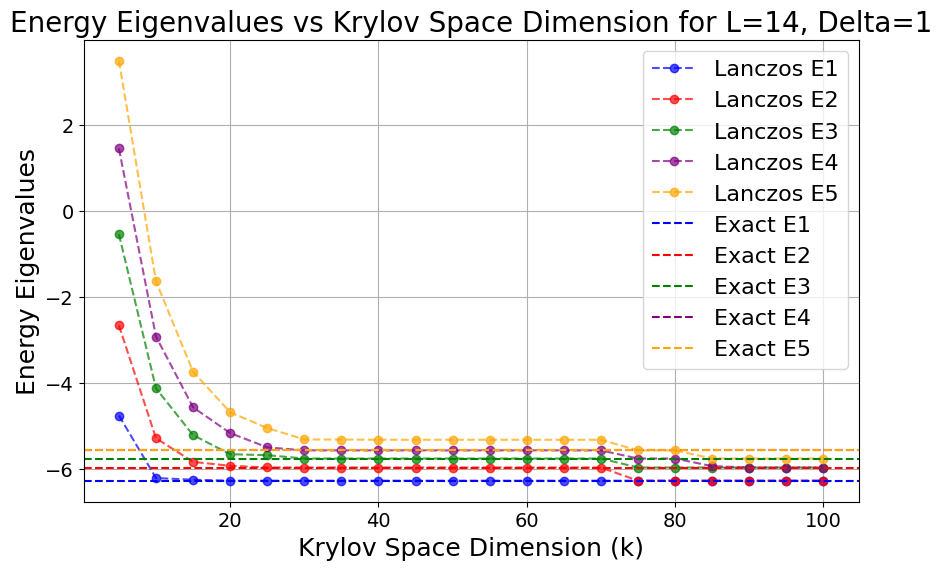

In [12]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

# Spin operators
Sx = sigma_x / 2
Sy = sigma_y / 2
Sz = sigma_z / 2
Sp = np.array([[0, 1], [0, 0]], dtype=complex)
Sm = np.array([[0, 0], [1, 0]], dtype=complex)

# Parameters for comparison
L = 14
Delta = 1
Mz = 0
H_full = generate_hamiltonian(L, Delta)
states = get_states_in_sector(L, Mz)
H_reduced = H_full[np.ix_(states, states)]

# Exact diagonalization
exact_eigenvalues = eigh(H_reduced, eigvals_only=True)[:5]

# Lanczos results for varying Krylov dimensions
k_values = list(range(5, 101, 5))
lanczos_results = [lanczos(H_reduced, num_eigenvalues=5, max_iter=k) for k in k_values]


with open("Data02/c_krylov.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Krylov Dimension (k)", "Eigenvalue Index", "Lanczos Eigenvalue", "Exact Eigenvalue"])
    # Write data
    for k_idx, k in enumerate(k_values):
        for i in range(len(exact_eigenvalues)):  # Loop over eigenvalue indices
            lanczos_value = lanczos_results[k_idx][i] if k_idx < len(lanczos_results) and i < len(lanczos_results[k_idx]) else None
            exact_value = exact_eigenvalues[i] if i < len(exact_eigenvalues) else None
            writer.writerow([k, i + 1, lanczos_value, exact_value])

# Plotting the comparison
colors = ["blue", "red", "green", "purple", "orange"]
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(k_values, [l[i] for l in lanczos_results], label=f"Lanczos E{i+1}", marker='o', ls = '--', color = colors[i], alpha = 0.7)
for i, E in enumerate(exact_eigenvalues):
    plt.axhline(E, linestyle='--', label=f"Exact E{i+1}", color = colors[i])

plt.xlabel("Krylov Space Dimension (k)")
plt.ylabel("Energy Eigenvalues")
plt.legend()
plt.title(f"Energy Eigenvalues vs Krylov Space Dimension for L={L}, Delta={Delta}")
plt.grid()
plt.savefig("Plots02/c_krylov_space.png", bbox_inches = "tight")
plt.show()

# d

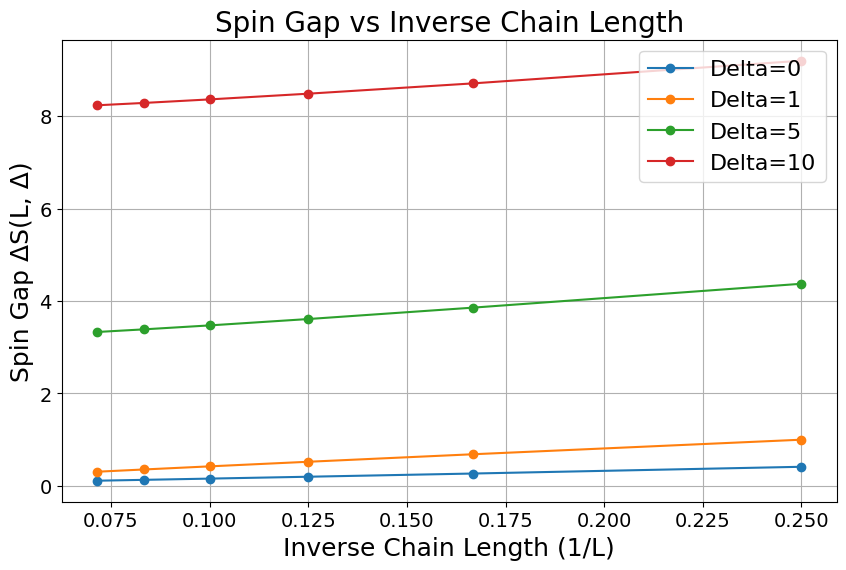

In [13]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

# Spin operators
Sx = sigma_x / 2
Sy = sigma_y / 2
Sz = sigma_z / 2
Sp = np.array([[0, 1], [0, 0]], dtype=complex)
Sm = np.array([[0, 0], [1, 0]], dtype=complex)


# Compute and plot spin gap
chain_lengths = [4, 6, 8, 10, 12, 14]
anisotropies = [0, 1, 5, 10]
spin_gaps = {Delta: [] for Delta in anisotropies}

for Delta in anisotropies:
    for L in chain_lengths:
        E0_Mz0 = ground_state_energy(L, Delta, 0)
        E0_Mz1 = ground_state_energy(L, Delta, 1)
        spin_gap = E0_Mz1 - E0_Mz0
        spin_gaps[Delta].append(spin_gap)


with open("Data02/d_spin_gaps.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["Chain Length (L)", "Anisotropy (Delta)", "Inverse Chain Length (1/L)", "Spin Gap (Delta_S)"])
        # Write data
        for Delta in anisotropies:
            for i, L in enumerate(chain_lengths):
                gap = spin_gaps[Delta][i]
                writer.writerow([L, Delta, 1/L, gap])


plt.figure(figsize=(10, 6))
for Delta, gaps in spin_gaps.items():
    plt.plot([1/L for L in chain_lengths], gaps, marker='o', label=f"Delta={Delta}")

plt.xlabel("Inverse Chain Length (1/L)")
plt.ylabel("Spin Gap ΔS(L, Δ)")
plt.title("Spin Gap vs Inverse Chain Length")
plt.legend()
plt.grid()
plt.savefig("Plots02/d_spin_gap.png", bbox_inches = "tight")
plt.show()